# Model NAME

- small description of the model (data normalization, model type, techniques used, ...)

- features used (hcpi_m, anything else?)

- version (update of other model? what did you change?)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

read the df and filter 2010 to 2023

In [2]:
hcpi = pd.read_parquet("data/hcpi_m.parquet").loc["2010-01":"2023-12"]

print(hcpi.shape)
hcpi.head(3)

(168, 185)


,ABW,AFG,AGO,ALB,ARE,ARG,ARM,ATG,AUT,AZE,...,VCT,VEN,VGB,VNM,WSM,XKX,YEM,ZAF,ZMB,ZWE
2010-01-01,90.518,73.652677,18.297409,82.400000,88.008742,NaN,97.670572,86.417242,89.04379,97.2,...,100.0,166.5,NaN,58.542273,90.343792,87.955386,110.846,75.30460,105.0,1.871011
2010-02-01,90.396,72.992480,18.459746,83.600000,87.859764,NaN,97.571898,86.617995,89.20885,98.3,...,100.1,169.1,NaN,59.689701,91.718191,88.191825,111.095,75.77624,105.5,1.887481
2010-03-01,90.623,72.924208,18.654168,83.691822,87.943564,NaN,98.220672,86.596486,90.19913,99.6,...,100.2,173.2,NaN,60.137374,92.084697,88.113012,111.469,76.40508,106.6,1.910539


In [3]:
# count columns with missing values
missing = hcpi.isna().sum()
print(f"We still have {hcpi.shape[1] - len(missing[missing > 0])} countries out of {hcpi.shape[1]}.")

We still have 163 countries out of 185.


# IDENTIFYING ANOMALIES BY COUNTRY

In [4]:
port_ts = pd.read_parquet("data/hcpi_m.parquet").loc[:, "PRT"]
print(f"No missing values? {port_ts.isna().sum() == 0}")

port_ts

No missing values? True


1970-01-01      1.702706
1970-02-01      1.680877
1970-03-01      1.716598
1970-04-01      1.706675
1970-05-01      1.687823
                 ...    
2024-11-01    122.043000
2024-12-01    122.173000
2025-01-01    121.622000
2025-02-01    121.489000
2025-03-01    123.217000
Name: PRT, Length: 663, dtype: float64

## stream + rolling window

In [5]:
class LSTMAE(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, seq_len=12):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        dec_input = h.repeat(self.seq_len, 1, 1).permute(1, 0, 2)
        dec_output, _ = self.decoder(dec_input)
        return dec_output


def sliding_windows(series, seq_len):
    X, idx = [], []
    for i in range(len(series) - seq_len):
        window = series[i:i+seq_len]
        X.append(window)
        idx.append(i + seq_len - 1)
    return np.array(X), np.array(idx)

def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std, mean, std

In [6]:
# --- Data ---
seq_len = 12
series = port_ts.values.astype(np.float32)
dates = port_ts.index.to_list()

X_raw, idx_all = sliding_windows(series, seq_len)
split_point = int(len(X_raw) * 0.8)
X_train_raw, X_test_raw = X_raw[:split_point], X_raw[split_point:]
idx_train, idx_test = idx_all[:split_point], idx_all[split_point:]

X_train_norm, mean, std = normalize(X_train_raw)
X_train_tensor = torch.tensor(X_train_norm[..., np.newaxis], dtype=torch.float32)


In [7]:
# --- Initial Train ---
model = LSTMAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, X_train_tensor)
    loss.backward()
    optimizer.step()

# threshold from initial model
model.eval()
with torch.no_grad():
    recon = model(X_train_tensor)
    train_errors = torch.mean((recon - X_train_tensor)**2, dim=(1,2)).numpy()
    threshold = np.percentile(train_errors, 95)


In [8]:
# --- Streaming anomaly detection ---
stream_series = series[split_point:]
stream_dates = dates[split_point:]

anomaly_dates = []
anomaly_points = []
expanding_X = list(X_train_raw.copy())  # start with training

for t in range(seq_len, len(stream_series)):
    window = stream_series[t-seq_len:t]
    date_t = stream_dates[t]

    x_norm = (window - mean) / std
    x_tensor = torch.tensor(x_norm[np.newaxis, :, np.newaxis], dtype=torch.float32)

    with torch.no_grad():
        recon = model(x_tensor)
        err = torch.mean((recon - x_tensor)**2).item()

    if err > threshold:
        print(f"{date_t.strftime('%Y-%m')}  anomaly  (error={err:.4f})")
        anomaly_dates.append(date_t)
        anomaly_points.append(port_ts[date_t])

    # Add new window to training set
    expanding_X.append(window)
    X_train_tensor = torch.tensor((np.array(expanding_X) - mean) / std, dtype=torch.float32)[..., np.newaxis]

    # Online retraining: small update
    for _ in range(5):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, X_train_tensor)
        loss.backward()
        optimizer.step()


2014-05  anomaly  (error=0.8272)
2014-06  anomaly  (error=0.7383)
2022-10  anomaly  (error=0.7055)
2022-11  anomaly  (error=0.7494)
2022-12  anomaly  (error=0.7928)
2023-01  anomaly  (error=0.8349)
2023-02  anomaly  (error=0.8720)
2023-03  anomaly  (error=0.9117)
2023-04  anomaly  (error=0.9508)
2023-05  anomaly  (error=0.9819)
2023-06  anomaly  (error=1.0039)
2023-07  anomaly  (error=1.0220)
2023-08  anomaly  (error=1.0383)
2023-09  anomaly  (error=1.0601)
2023-10  anomaly  (error=1.0819)
2023-11  anomaly  (error=1.0943)
2023-12  anomaly  (error=1.1025)
2024-01  anomaly  (error=1.1094)
2024-02  anomaly  (error=1.1230)
2024-03  anomaly  (error=1.1371)
2024-04  anomaly  (error=1.1516)
2024-05  anomaly  (error=1.1643)
2024-06  anomaly  (error=1.1833)
2024-07  anomaly  (error=1.2001)
2024-08  anomaly  (error=1.2161)
2024-09  anomaly  (error=1.2287)
2024-10  anomaly  (error=1.2414)
2024-11  anomaly  (error=1.2555)
2024-12  anomaly  (error=1.2704)
2025-01  anomaly  (error=1.2892)
2025-02  a

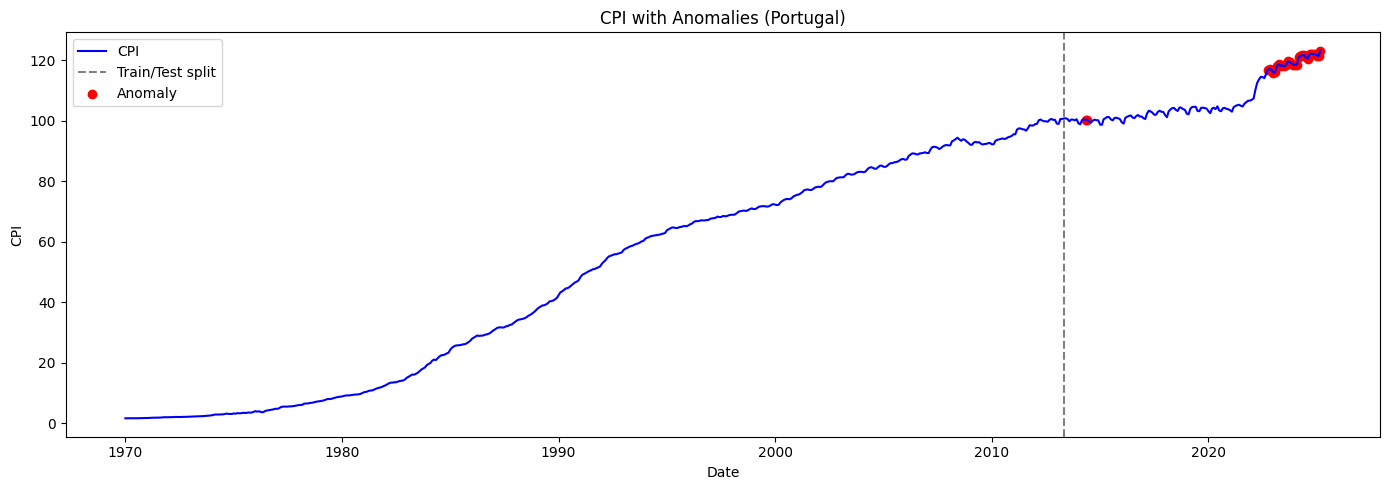

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(dates, series, label="CPI", color='blue')
plt.axvline(x=dates[split_point], color='gray', linestyle='--', label='Train/Test split')
plt.scatter(anomaly_dates, anomaly_points, color='red', label='Anomaly')
plt.title("CPI with Anomalies (Portugal)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.tight_layout()
plt.show()


**SOLUTIONS:**

- Use prediction-based anomaly detection

- Freeze the model (no online training) and retrain only yearly

- Lower the anomaly threshold

## prediction-based

In [10]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, seq_len=12):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.seq_len = seq_len

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out.squeeze()
    

def make_supervised(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

def normalize(series, mean=None, std=None):
    if mean is None:
        mean = np.mean(series)
        std = np.std(series)
    return (series - mean) / std, mean, std

In [11]:
seq_len = 12
series = port_ts.values.astype(np.float32)
dates = port_ts.index.to_list()

split_idx = int(0.8 * len(series))
train_series = series[:split_idx]
test_series = series[split_idx:]
test_dates = dates[split_idx:]

train_norm, mean, std = normalize(train_series)
test_norm, _, _ = normalize(test_series, mean, std)

X_train, y_train = make_supervised(train_norm, seq_len)
X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)


In [12]:
model = LSTMPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# residuals from training
model.eval()
with torch.no_grad():
    preds = model(X_train_tensor)
    residuals = torch.abs(preds - y_train_tensor).numpy()
    threshold = np.percentile(residuals, 95)


In [13]:
anomaly_dates = []
anomaly_values = []
retrain_every = 6

stream_buffer = list(train_series.copy())
stream_dates = test_dates
stream_vals = test_series
month_counter = 0

for t in range(seq_len, len(stream_vals)):
    window = stream_vals[t-seq_len:t]
    true_val = stream_vals[t]
    date_t = stream_dates[t]

    # normalize window using fixed mean/std
    x = (window - mean) / std
    x_tensor = torch.tensor(x[np.newaxis, :, np.newaxis], dtype=torch.float32)

    with torch.no_grad():
        pred = model(x_tensor).item()
        err = abs(pred - (true_val - mean) / std)

    if err > threshold:
        print(f"{date_t.strftime('%Y-%m')}  anomaly (error={err:.4f})")
        anomaly_dates.append(date_t)
        anomaly_values.append(true_val)

    # Expand training data
    stream_buffer.append(true_val)
    month_counter += 1

    # Periodic retrain
    if month_counter % retrain_every == 0:
        new_train = np.array(stream_buffer)
        new_train_norm, mean, std = normalize(new_train)
        X_new, y_new = make_supervised(new_train_norm, seq_len)
        X_train_tensor = torch.tensor(X_new[..., np.newaxis], dtype=torch.float32)
        y_train_tensor = torch.tensor(y_new, dtype=torch.float32)

        model = LSTMPredictor()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        for _ in range(50):  # fewer epochs
            optimizer.zero_grad()
            out = model(X_train_tensor)
            loss = criterion(out, y_train_tensor)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            preds = model(X_train_tensor)
            residuals = torch.abs(preds - y_train_tensor).numpy()
            threshold = np.percentile(residuals, 95)


2015-03  anomaly (error=0.5900)
2015-04  anomaly (error=0.5973)
2015-05  anomaly (error=0.6090)
2015-06  anomaly (error=0.6060)
2015-07  anomaly (error=0.5849)
2015-08  anomaly (error=0.5759)
2015-09  anomaly (error=1.1491)
2015-10  anomaly (error=1.1510)
2015-11  anomaly (error=1.1450)
2015-12  anomaly (error=1.1374)
2016-01  anomaly (error=1.1079)
2016-09  anomaly (error=1.1463)
2016-10  anomaly (error=1.1554)
2016-11  anomaly (error=1.1398)
2016-12  anomaly (error=1.1410)
2017-01  anomaly (error=1.1241)
2017-02  anomaly (error=1.1186)
2017-03  anomaly (error=1.1166)
2017-04  anomaly (error=1.1433)
2017-05  anomaly (error=1.1347)
2017-06  anomaly (error=1.1215)
2017-07  anomaly (error=1.1014)
2017-08  anomaly (error=1.1016)
2019-03  anomaly (error=1.0163)
2019-04  anomaly (error=1.0333)
2019-05  anomaly (error=1.0343)
2019-06  anomaly (error=1.0345)
2019-07  anomaly (error=0.9964)
2019-08  anomaly (error=0.9930)
2019-09  anomaly (error=0.9696)
2019-10  anomaly (error=0.9697)
2019-11 

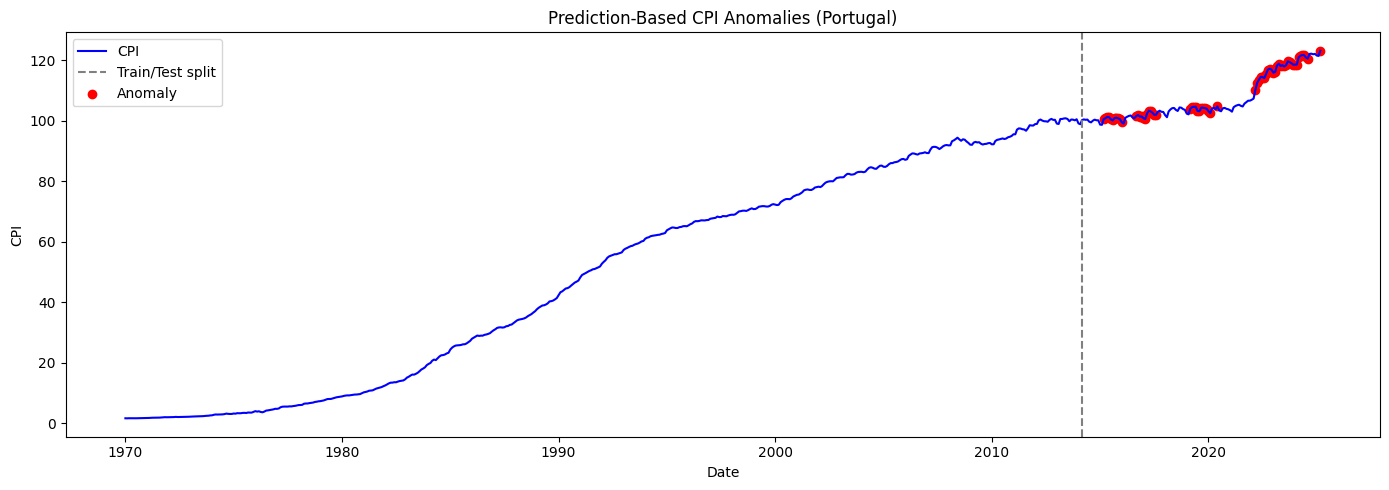

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(dates, series, label="CPI", color='blue')
plt.axvline(x=dates[split_idx], color='gray', linestyle='--', label='Train/Test split')
plt.scatter(anomaly_dates, anomaly_values, color='red', label='Anomaly')
plt.title("Prediction-Based CPI Anomalies (Portugal)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.tight_layout()
plt.show()
